In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
  ! curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
! git clone https://github.com/ryuntp/floodDetection.git

fatal: destination path 'floodDetection' already exists and is not an empty directory.


In [0]:
path = Path('floodDetection')

In [0]:
path_labels = path/"labels"
path_images = path/'images'

In [7]:
filenames = get_image_files(path_images)
filenames[:10]

[PosixPath('floodDetection/images/Label_52.png'),
 PosixPath('floodDetection/images/Label_45.png'),
 PosixPath('floodDetection/images/Label_58.png'),
 PosixPath('floodDetection/images/Label_47.png'),
 PosixPath('floodDetection/images/Label_37.png'),
 PosixPath('floodDetection/images/Label_65.png'),
 PosixPath('floodDetection/images/Label_36.png'),
 PosixPath('floodDetection/images/Label_26.png'),
 PosixPath('floodDetection/images/Label_9.png'),
 PosixPath('floodDetection/images/Label_6.png')]

In [8]:
label_names = get_image_files(path_labels)
label_names[:10]

[PosixPath('floodDetection/labels/Label_6_P.png'),
 PosixPath('floodDetection/labels/Label_14_P.png'),
 PosixPath('floodDetection/labels/Label_19_P.png'),
 PosixPath('floodDetection/labels/Label_58_P.png'),
 PosixPath('floodDetection/labels/Label_33_P.png'),
 PosixPath('floodDetection/labels/Label_48_P.png'),
 PosixPath('floodDetection/labels/Label_30_P.png'),
 PosixPath('floodDetection/labels/Label_26_P.png'),
 PosixPath('floodDetection/labels/Label_44_P.png'),
 PosixPath('floodDetection/labels/Label_4_P.png')]

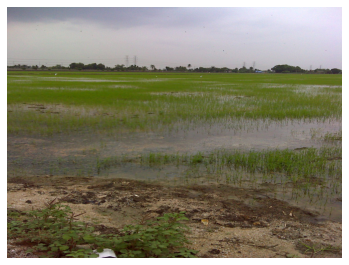

In [9]:
image_file = filenames[29]
image = open_image(image_file)
image.show(figsize=(6,6))

In [0]:
get_y_fn = lambda x: str(path_labels)+"/"+ f'{x.stem}_P{x.suffix}'

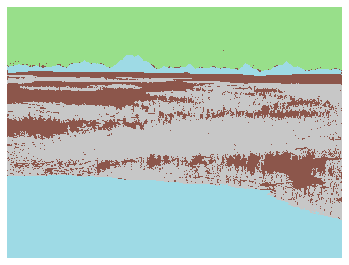

In [11]:
mask = open_mask(get_y_fn(image_file))
mask.show(figsize=(6,6), alpha=1)

In [12]:
source_size = np.array(mask.shape[1:])
source_size, mask.data

(array([720, 960]), tensor([[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4],
          [4, 4, 4,  ..., 4, 4, 4]]]))

In [13]:
codes = np.loadtxt(path/'code.txt', dtype=str)
len(codes), codes

(5, array(['Void', 'sky', 'rice', 'water', 'backg'], dtype='<U5'))

In [14]:
size = source_size//2
bs = 0

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 16000: bs=16    
elif free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=16, have 16270MB of GPU RAM free


In [0]:
segmentitemlist = (SegmentationItemList.from_folder(path_images)
              .split_by_rand_pct(valid_pct=0.2)
              .label_from_func(get_y_fn, classes=codes))
# print(segmentitemlist)

In [0]:
databunch = (segmentitemlist.transform(get_transforms(), 
                                  size=size, tfm_y=True)
             .databunch(bs=bs)
             .normalize(imagenet_stats))

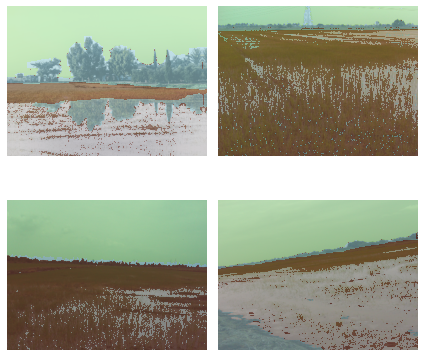

In [17]:
databunch.show_batch(2, figsize=(6, 6))

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

In [0]:
wd=1e-2

In [0]:
learner = unet_learner(databunch, models.resnet34, 
                       metrics=metrics, wd=wd, 
                       callback_fns=ShowGraph, 
                       ).to_fp16()

In [22]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-03
Min loss divided by 10: 1.91E-05


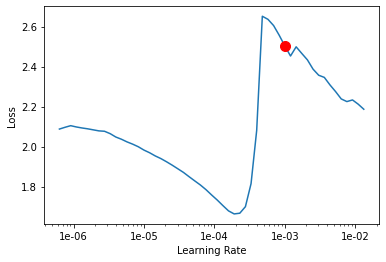

In [23]:
learner.recorder.plot(suggestion=True)

In [0]:
lr=1e-3

epoch,train_loss,valid_loss,acc_camvid,time
0,1.801161,1.552410,0.171886,00:10
1,1.509193,2.512846,0.517353,00:05
2,1.477592,1.019854,0.639823,00:05
3,1.313405,0.865647,0.675320,00:05
4,1.203886,0.793737,0.720706,00:05
5,1.109156,0.688334,0.747857,00:05
6,1.020009,0.628583,0.730112,00:05
7,0.941098,0.502314,0.813310,00:05
8,0.873430,0.444451,0.838840,00:05
9,0.817332,0.439889,0.838257,00:05


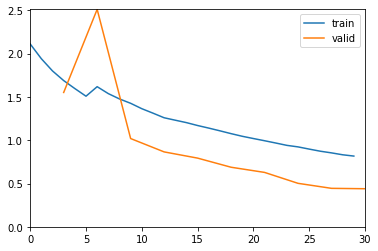

In [25]:
learner.fit_one_cycle(10, lr, pct_start=0.4)

In [0]:
learner.save('unet-resnet34-1')

In [0]:
learner.load('unet-resnet34-1');

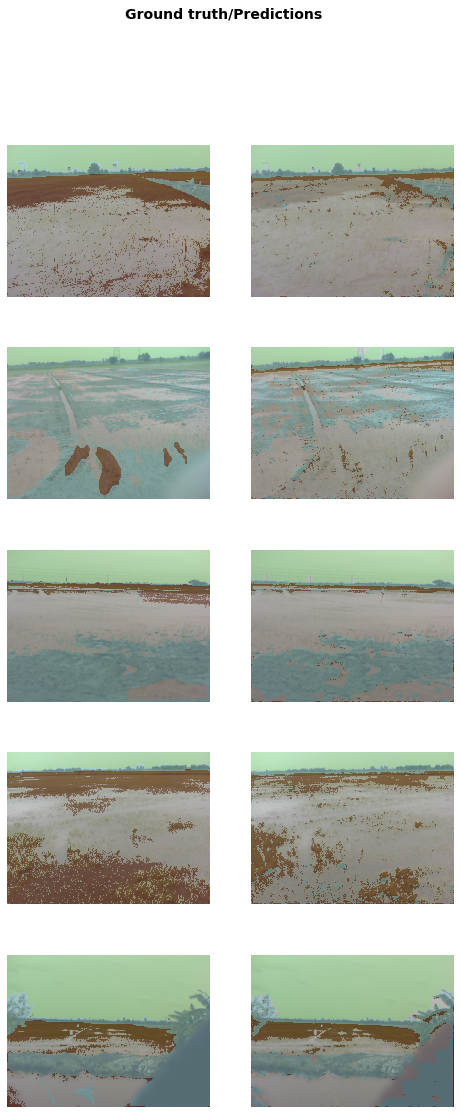

In [29]:
learner.show_results(rows=5, figsize=(8, 18))

In [0]:
learner.unfreeze()

In [31]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


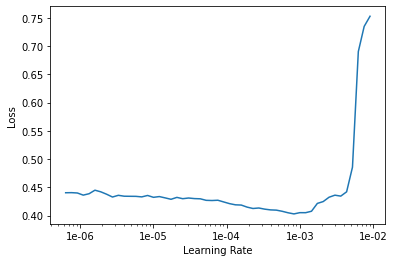

In [32]:
learner.recorder.plot()

epoch,train_loss,valid_loss,acc_camvid,time
0,0.423174,0.450221,0.831776,00:06
1,0.416995,0.473430,0.819107,00:06
2,0.422579,0.419664,0.841039,00:06
3,0.415314,0.448738,0.831469,00:06
4,0.402606,0.470240,0.814675,00:06
5,0.400682,0.493011,0.819702,00:06
6,0.389130,0.399114,0.850003,00:06
7,0.383589,0.391498,0.853091,00:06
8,0.374273,0.388250,0.854213,00:06
9,0.366524,0.388544,0.854410,00:06


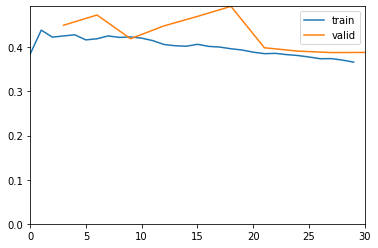

In [33]:
learner.fit_one_cycle(10, max_lr=slice(3e-6, 3e-4))

In [0]:
learner.save('unet-resnet34-2')

In [0]:
learner.load('unet-resnet34-2');

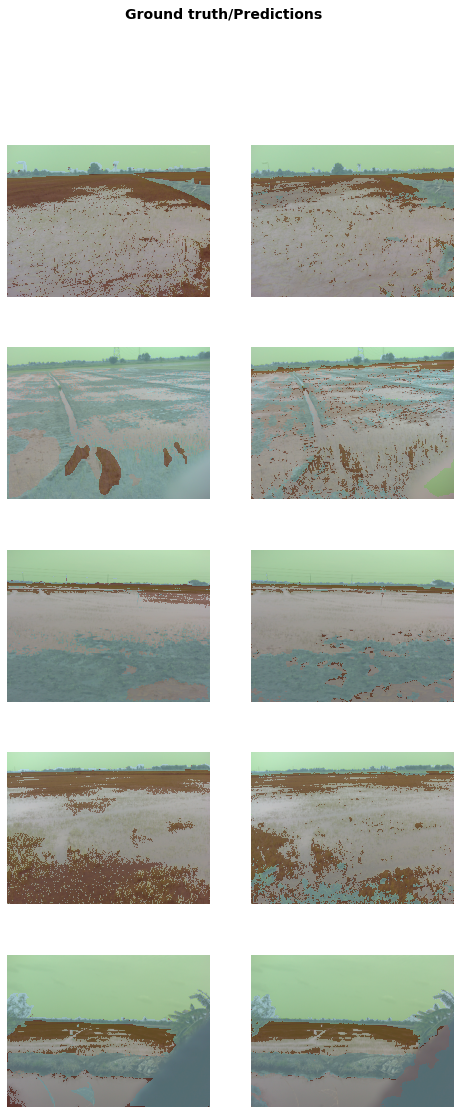

In [36]:
learner.show_results(rows=5, figsize=(8, 18))